In [2]:
from collections import defaultdict
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
from PIL import Image
import pytorch_ssim
from scipy.special import softmax
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

### Numpy Testing

In [15]:
A = np.array([5, 10])
B = np.array([5, 20])

In [16]:
A / ( A + B)

array([0.5       , 0.33333333])

In [17]:
print(test)

[0.30162373 0.28992029 0.96960259 0.97580711 0.97698793 0.18015799
 0.4222087  0.1396285  0.42311095 0.55953051]


In [13]:
p = np.random.rand(10)
print(p)
test = np.random.rand(10)
A = np.random.randint(0, 10, 10)
B = np.random.randint(-20, -10, 10)

[0.99298434 0.674722   0.32502604 0.53216945 0.75759258 0.42652095
 0.91761595 0.03745004 0.75179827 0.65531285]


In [14]:
np.where(test < p, A, B)

array([  4,   6, -12, -19, -19,   0,   6, -16,   5,   6])

In [24]:
test = np.concatenate([np.arange(0, 5), np.arange(19992, 20000)])
test

array([    0,     1,     2,     3,     4, 19992, 19993, 19994, 19995,
       19996, 19997, 19998, 19999])

In [14]:
test = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0])
A = np.array([101, 102, 103, 104, 0, 1, 2, 3, 4, 5])
A[np.nonzero(test)[0]]

array([104,   2])

In [16]:
np.maximum([1, 2, 3], [4, 1, 2])

array([4, 2, 3])

In [2]:
softmax(-1 * np.array([60.123, 60.001, 180.123]))

array([4.69537774e-01, 5.30462226e-01, 3.60025041e-53])

In [51]:
test = np.random.random((5, 5))

In [55]:
non_edges = test < 0.5
non_edges

array([[ True,  True,  True, False,  True],
       [False,  True,  True, False, False],
       [ True,  True, False,  True, False],
       [ True,  True, False, False,  True],
       [ True,  True,  True, False, False]])

In [57]:
np.logical_not(non_edges)

array([[False, False, False,  True, False],
       [ True, False, False,  True,  True],
       [False, False,  True, False,  True],
       [False, False,  True,  True, False],
       [False, False, False,  True,  True]])

In [53]:
for index, i in np.ndenumerate(test):
    print(index, i)

(0, 0) 0.23894487445563517
(0, 1) 0.041147207249221496
(0, 2) 0.15642911888342204
(0, 3) 0.6714956038437602
(0, 4) 0.10900146128460797
(1, 0) 0.7189960350746424
(1, 1) 0.3754380742103265
(1, 2) 0.3003984095031955
(1, 3) 0.5514396277936443
(1, 4) 0.8812289558940523
(2, 0) 0.019828722050789005
(2, 1) 0.06745948208077102
(2, 2) 0.6472394080255639
(2, 3) 0.16757883237012194
(2, 4) 0.780418138743207
(3, 0) 0.4272876882766756
(3, 1) 0.04741066485854717
(3, 2) 0.888499754048982
(3, 3) 0.6738071070380899
(3, 4) 0.2185879318383438
(4, 0) 0.09529517083647387
(4, 1) 0.3536672756713717
(4, 2) 0.017155123578281195
(4, 3) 0.8493437532855275
(4, 4) 0.6197769914717918


In [25]:
test = np.array([[0, 0], [0, 0]])
test.shape

(2, 2)

In [26]:
test = np.append(test, np.zeros((2, 1)), axis=1)
test.shape

(2, 3)

In [28]:
test = np.append(test, np.zeros((1, 3)), axis=0)
test.shape

(3, 3)

In [31]:
test[2, :] = 1
test[:, 2] = 1

In [35]:
np.clip(test, 1, None)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [68]:
x = np.array([5, 6, 7, 9])

In [69]:
m = softmax(-1 * x)
m

array([0.65723302, 0.24178252, 0.08894682, 0.01203764])

In [70]:
np.random.choice(x, p=m)

5

### NetworkX Testing

In [48]:
G = nx.Graph()
nx.add_path(G, [0, 1, 2])
nx.add_path(G, [0, 10, 2])

In [50]:
list(nx.all_shortest_paths(G, source=0, target=2))

[[0, 1, 2], [0, 10, 2]]

### Environment Testing

In [43]:
with open('../experiments/configs/test.json') as f:
    config = json.load(f)

mode = config['mode']
minigrid_config = config['eval_env']
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


In [59]:
test = np.zeros((25, 25)) - 1  

In [60]:
for room in env.rooms:
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            test[(x, y)] += 1

    if room.exitDoorPos is not None:
        test[room.exitDoorPos] += 1

In [61]:
landmarks = set()

In [62]:
for room in env.rooms:
    x = room.top[0] + (room.size[0] - 1) // 2
    y = room.top[1] + (room.size[1] - 1) // 2
    test[(x, y)] += 5
    landmarks.add((x, y))
    
    if room.exitDoorPos is not None:
        landmarks.add(room.exitDoorPos)
        test[room.exitDoorPos] += 10

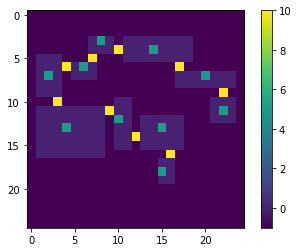

In [63]:
plt.imshow(test.T)
plt.colorbar()

In [64]:
len(landmarks)

19

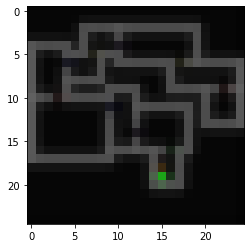

In [65]:
env.unwrapped.agent_pos = np.array([15, 18])
plt.imshow(env.get_current_state()[0])

In [37]:
env.unwrapped.agent_pos = np.array([16, 19])

In [38]:
o, r, d, info = env.step(2)

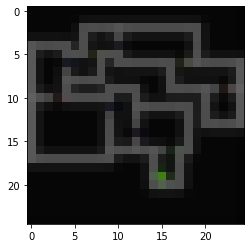

In [32]:
plt.imshow(o)

In [35]:
true_dist = env.get_true_distances()

In [92]:
from rlpyt.agents.dqn.dsr.landmark_agent import get_true_pos

In [103]:
obs = env.reset()
true_pos = get_true_pos(obs)
true_pos

[7, 4]

In [104]:
obs = env.step(3)[0]
next_pos = get_true_pos(obs)
next_pos

[7, 3]

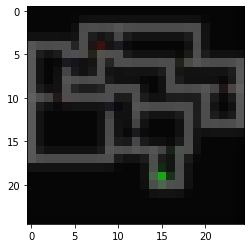

In [96]:
plt.imshow(obs)

In [ ]:
obs = env.reset()
plt.imshow(obs)
steps = int(5e3)

In [ ]:
h, w = env.grid.height, env.grid.width
incorrect_states = []

num_states = 0
dist_matrix = np.zeros((h * w, h * w))
valid = set()

for room in env.rooms:
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            valid.add((x, y))
    
    if room.exitDoorPos is not None:
        valid.add(room.exitDoorPos)

In [ ]:
for pos in valid:
    x, y = pos
    
    true_pos = y * h + x
    
    for adjacent in [[x-1, y], [x, y-1], [x+1, y], [x, y+1]]:
        adj_x, adj_y = adjacent
        if (adj_x, adj_y) in valid:
            true_adj_pos = adj_y * h + adj_x
            dist_matrix[true_pos, true_adj_pos] = 1

In [ ]:
G = nx.from_numpy_array(dist_matrix)

In [ ]:
lengths = nx.shortest_path_length(G)

In [ ]:
true_dist = np.zeros((w, h, w, h)) - 1

In [ ]:
for source, targets in lengths:
    source_x, source_y = source % h, source // h
    for target, dist in targets.items():
        target_x, target_y = target % h, target // h
        true_dist[source_x, source_y, target_x, target_y] = dist

In [ ]:
true_dist[15, 19, 3, 11]

In [ ]:
for i in range(steps):
    _, _, d, _ = env.step(env.action_space.sample())
    if d:
        print('{} steps done!'.format(i))
        env.reset()

In [ ]:
plt.imshow(env.visited.T)
plt.colorbar()

### Visualize Subgoal Policy

In [2]:
def visualize_subgoal_policy(run, itr, subgoal, q_mode=None):
    config_file = '../data/local/{}/params.json'.format(run)
    with open(config_file, 'r') as f:
        config = json.load(f)
    mode = config['mode']
    seed = config['seed']
    config['env']['oracle'] = False
    set_seed(seed)

    device = torch.device('cuda', index=0)

    ENV_ID = 'MiniGrid-FourRooms-v0'
    env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
    obs = env.reset()
#     plt.imshow(obs)
    
    dsr = torch.load('../data/local/{}/dsr_itr_{}.pt'.format(run, itr)).detach().cpu().numpy()
    action_dsr = dsr.mean(axis=2)  # normalize direction dimension
    normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

    if q_mode == 'sf':
        subgoal_dsr = normed_dsr[subgoal].mean(axis=0)
        subgoal_dsr = subgoal_dsr / np.linalg.norm(subgoal_dsr, ord=2)
        q_values = np.dot(normed_dsr, subgoal_dsr)   
    elif q_mode == 'sf-look':
        avg_dsr = action_dsr.mean(axis=2)
        normed_avg_dsr = avg_dsr / np.linalg.norm(avg_dsr, ord=2, axis=2, keepdims=True)
        subgoal_dsr = normed_avg_dsr[subgoal]
        
        side_size = normed_avg_dsr.shape[0]
        q_values = np.zeros(tuple(action_dsr.shape[:3])) + np.nan
        
        for x in range(side_size):
            for y in range(side_size):
                if any(np.isnan(normed_avg_dsr[x, y])):
                    continue
                new_pos = [[x + 1, y], [x, y + 1], [x - 1, y], [x, y - 1]]
                for i, pos in enumerate(new_pos):
                    n_x, n_y = pos
                    if n_x < 0 or n_x >= side_size or n_y < 0 or n_y >= side_size:
                        q_values[x, y, i] = -2
                    elif any(np.isnan(normed_avg_dsr[n_x, n_y])):
                        q_values[x, y, i] = -2
                    else:
                        q_values[x, y, i] = np.dot(normed_avg_dsr[n_x, n_y], subgoal_dsr)

    else:
        params = torch.load('../data/local/{}/itr_{}.pkl'.format(run, itr), map_location=device)
        feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
        feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
        feature_model.to(device)

        env.unwrapped.agent_pos = np.array(subgoal)

        obs = env.get_current_state()[0]
        obs = torch.Tensor(obs).unsqueeze(0)
        features = feature_model(obs.to(device), mode='encode')
        features = features.squeeze().detach().cpu().numpy()
        normed_features = features / np.linalg.norm(features, ord=2)

        q_values = np.dot(normed_dsr, normed_features)
    
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(q_values.max(axis=2).T)
    for x in range(q_values.shape[0]):
        plt.axvline(x + 0.5, color='k', linestyle=':')
        for y in range(q_values.shape[1]):
            plt.axhline(y + 0.5, color='k', linestyle=':')

            if (x, y) == subgoal:
                circle = plt.Circle((x, y), 0.2, color='r')
                plt.gca().add_artist(circle)

            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')
    plt.colorbar()

using seed 333
using seed 333
using seed 333


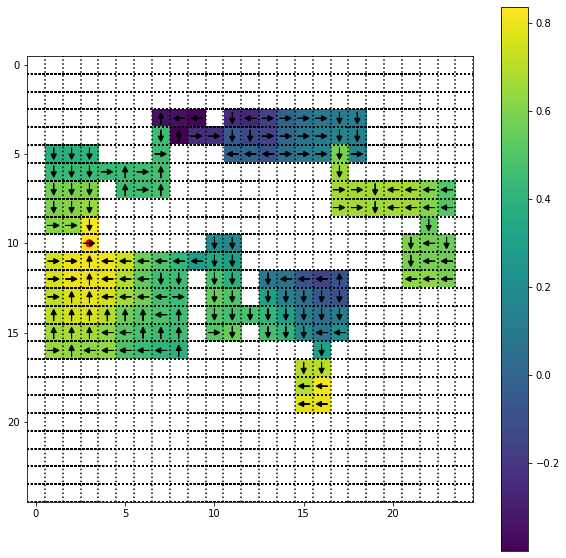

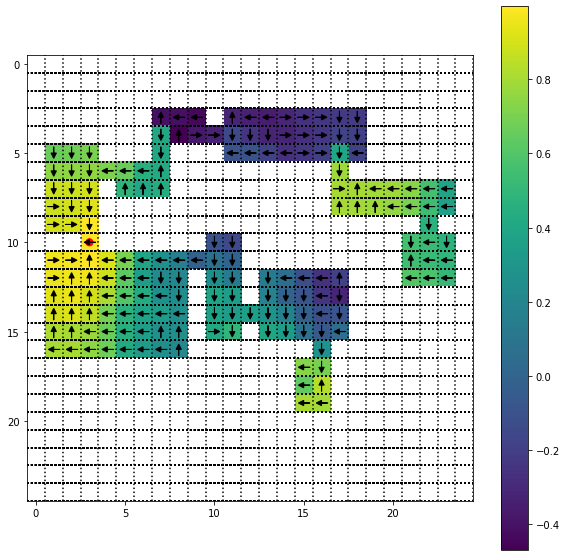

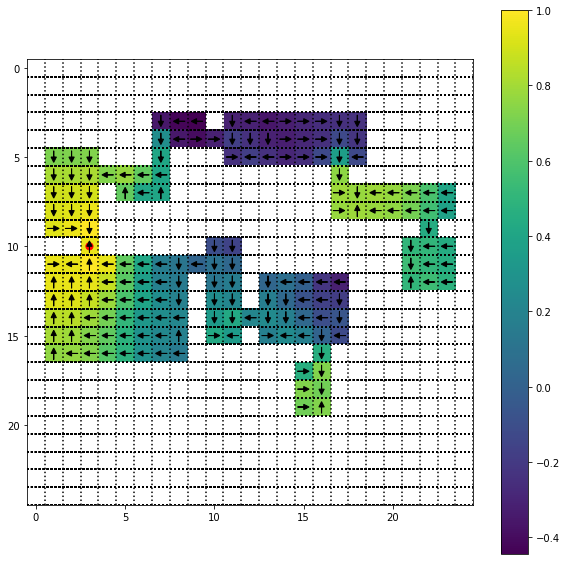

In [32]:
# Random agent
subgoal = (3, 10)
run = '20200506/multiroom/run_0'
itr = 200000
itr -= 1
visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

using seed 333


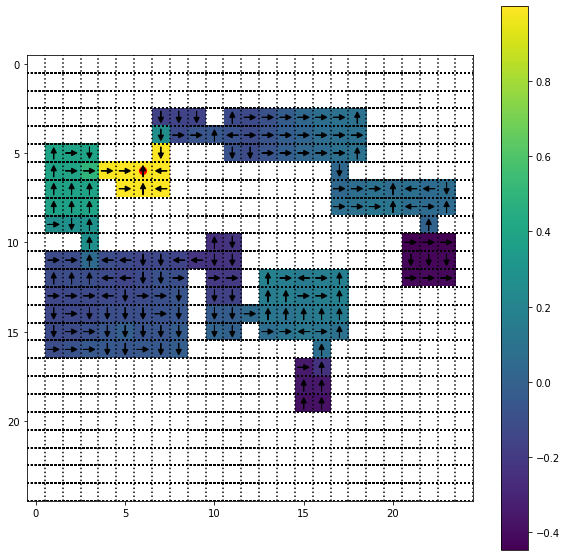

In [6]:
# perfect landmarks
subgoal = (6, 6)
run = '20200512/multiroom/run_30'
itr = 200000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

using seed 333


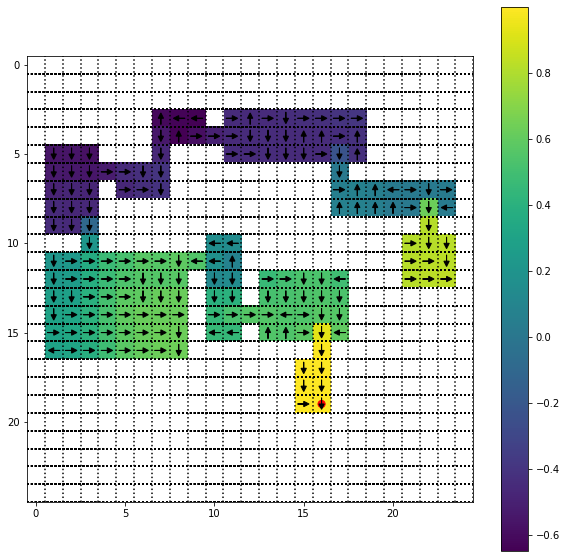

In [18]:
# Online landmarks in training only
subgoal = (16, 19)
run = '20200512/multiroom/run_33'
itr = 150000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

using seed 333


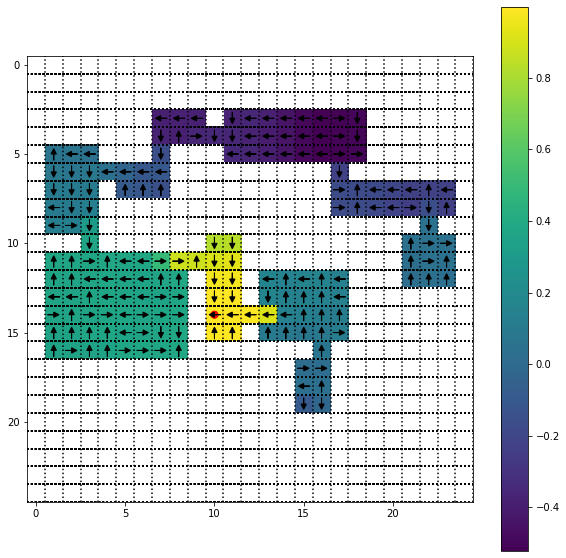

In [12]:
# Estimated landmark graph
subgoal = (10, 14)
run = '20200515/multiroom/run_69'
itr = 200000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [158]:
run = '20200513/multiroom/run_41'
itr = 20000
itr -= 1

In [159]:
with open('../data/local/{}/params.json'.format(run)) as f:
    config = json.load(f)

mode = config['mode']
minigrid_config = config['eval_env']
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

device = torch.device('cuda', 0)

using seed 333


In [160]:
params = torch.load('../data/local/{}/itr_{}.pkl'.format(run, itr))

In [161]:
del model
model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
model.load_state_dict(params['agent_state_dict']['idf_model'])
model.to(device)

IDFModel(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=1600, out_features=64, bias=True)
  )
  (inverse): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [162]:
h, w = env.grid.height, env.grid.width
features = torch.zeros((h, w, 4, 64), dtype=torch.float)
features += np.nan

for pos in env.get_possible_pos():
    x, y = pos
    for direction in range(4):
        env.unwrapped.agent_pos = np.array([x, y])
        env.unwrapped.agent_dir = direction
        obs, _, _, _ = env.get_current_state()
        model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)

        features[x, y, direction] = model(model_inputs, mode='encode')

In [163]:
subgoal = (3, 5)

np_features = features.detach().numpy()
features_matrix = np_features.mean(axis=2)
features_matrix = features_matrix / np.linalg.norm(features_matrix, ord=2, axis=2, keepdims=True)

subgoal_features = features_matrix[subgoal]

side_size = features_matrix.shape[0]
heatmap = np.zeros((side_size, side_size))
for r in range(side_size):
    for c in range(side_size):
#         heatmap[r, c] = np.dot(features_matrix[r, c], subgoal_features)
        heatmap[r, c] = np.linalg.norm(features_matrix[r, c] - subgoal_features)

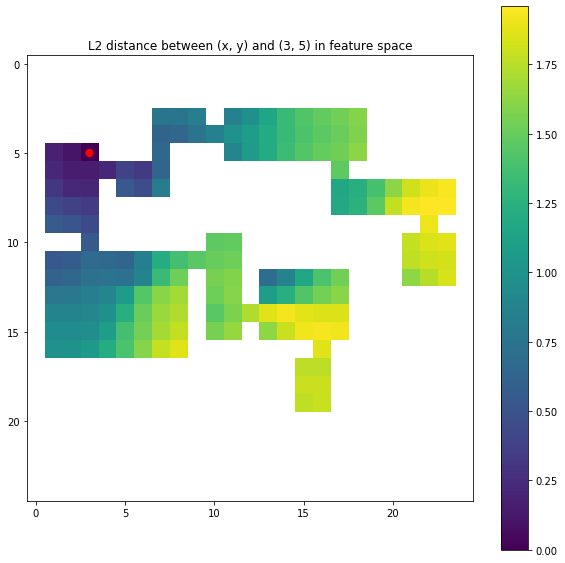

In [164]:
plt.figure(figsize=(10, 10))
plt.imshow(heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.title('L2 distance between (x, y) and {} in feature space'.format(subgoal))
plt.colorbar()

In [165]:
np_features = features.detach().numpy()
raw_features = np_features.mean(axis=2)
valid_features = raw_features.reshape(25 * 25, 64)
walls = np.isnan(valid_features).any(axis=1)
valid_features = valid_features[~walls]

In [166]:
rooms = np.zeros((25, 25))
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i
rooms = rooms.reshape(25 * 25)[~walls]

In [167]:
embeddings = TSNE(n_components=2).fit_transform(valid_features)

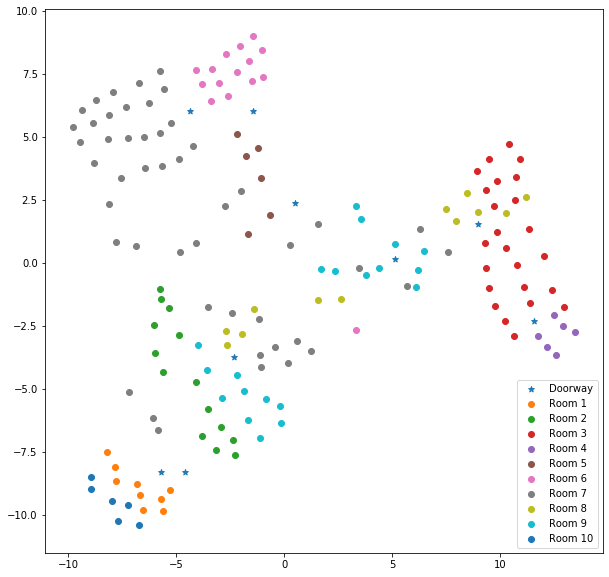

In [168]:
figure = plt.figure(figsize=(10, 10))
tsne_data = embeddings[rooms == 0]
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    tsne_data = embeddings[rooms == i]
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Room ' + str(i))
plt.legend()

### Successor Features Heatmap

In [10]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for x in range(side_size):
        for y in range(side_size):
            grid[x, y] = np.linalg.norm(sr_matrix[x, y] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


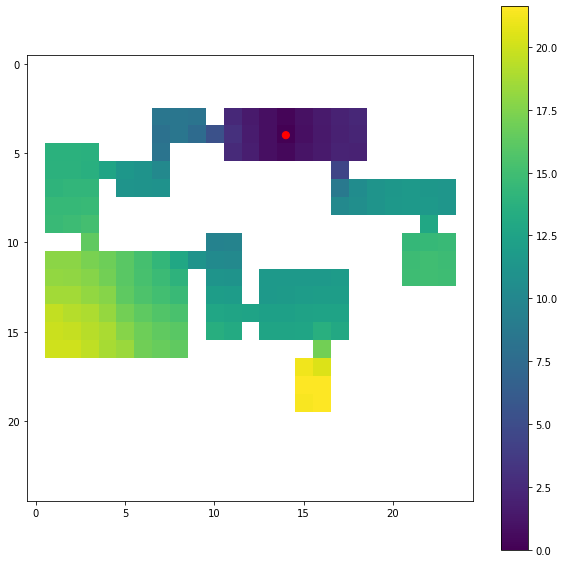

In [11]:
subgoal = (14, 4)
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200411-run0-100k.pt', subgoal, -1, -1, True)
figure = plt.figure(figsize=(10, 10))
plt.imshow(dsr_heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.colorbar()

### Subgoal Q-Values

In [12]:
from sklearn_extra.cluster import KMedoids

In [13]:
config_file = '../data/local/20200411/multiroom/run_0/params.json'
with open(config_file, 'r') as f:
    config = json.load(f)

In [14]:
mode = config['mode']
seed = config['seed']
set_seed(seed)

device = torch.device('cuda', index=0)

using seed 333


In [15]:
checkpoint = '../data/local/20200411/multiroom/run_0/itr_99999.pkl'

In [16]:
params = torch.load(checkpoint, map_location=device)

In [17]:
ENV_ID = 'MiniGrid-FourRooms-v0'
env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
obs = env.reset()

In [18]:
feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
feature_model.to(device)

IDFModel(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=1600, out_features=64, bias=True)
  )
  (inverse): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [19]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()
action_dsr = dsr.mean(axis=2)  # normalize direction dimension
normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

### Find Landmarks

In [21]:
state_dsr = action_dsr.mean(axis=2)

In [22]:
raw_s_features = state_dsr.reshape(25 * 25, 64)

In [23]:
walls = np.isnan(raw_s_features).any(axis=1)
s_features = raw_s_features[~walls]

In [24]:
indices = np.array(list(itertools.product(range(25), range(25))))

In [25]:
kmedoids = KMedoids(n_clusters=8, random_state=seed).fit(s_features)
landmarks = kmedoids.medoid_indices_
landmark_states = indices[~walls][landmarks]
landmark_states

array([[ 9,  3],
       [ 1,  7],
       [10, 13],
       [21,  7],
       [15,  5],
       [ 4, 13],
       [15, 14],
       [15, 19]])

In [26]:
landmark_map = walls.astype(int).reshape(25, 25)
landmark_map[landmark_states[:, 0], landmark_states[:, 1]] = 2

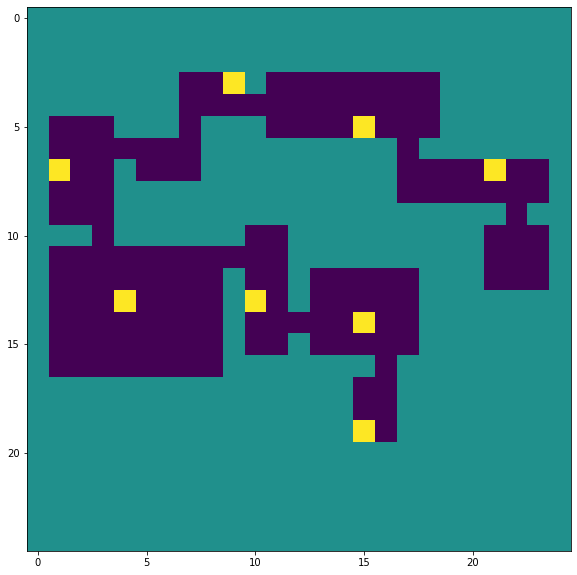

In [27]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(landmark_map.T)

### Subgoal Policy

In [37]:
subgoal = (14, 4)
env.unwrapped.agent_pos = np.array(subgoal)

obs = env.get_current_state()[0]
obs = torch.Tensor(obs).unsqueeze(0)
features = feature_model(obs.to(device), mode='encode')
features = features.squeeze().detach().cpu().numpy()
normed_features = features / np.linalg.norm(features, ord=2)



q_values = np.dot(normed_dsr, normed_features)

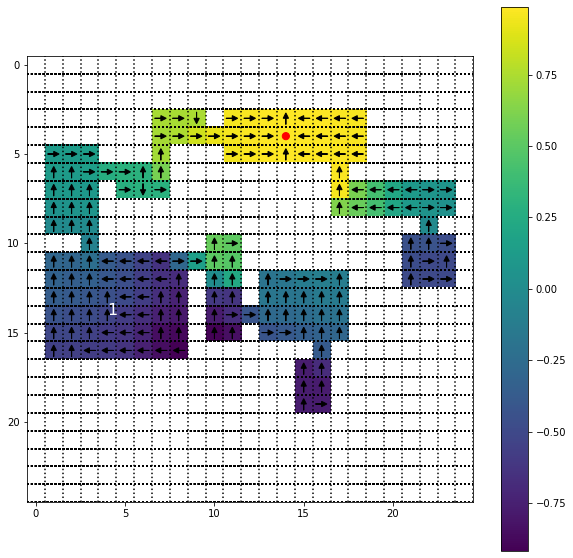

In [81]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(q_values.max(axis=2).T)
for x in range(q_values.shape[0]):
    plt.axvline(x + 0.5, color='k', linestyle=':')
    for y in range(q_values.shape[1]):
        plt.axhline(y + 0.5, color='k', linestyle=':')
        
        if (x, y) == subgoal:
            circle = plt.Circle((x, y), 0.2, color='r')
            plt.gca().add_artist(circle)
        else:
            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')

            
plt.colorbar()

### T-SNE Plots

In [80]:
import itertools
from sklearn.manifold import TSNE

In [81]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()

In [82]:
raw_sf = dsr.mean(axis=(2, 3))

In [83]:
s_features = raw_sf.reshape(25 * 25, 64)
walls = np.isnan(s_features).any(axis=1)
s_features = s_features[~walls]

In [84]:
sf_embedded = TSNE(n_components=2).fit_transform(s_features)

In [85]:
rooms = np.zeros((25, 25))

In [86]:
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i

In [87]:
rooms = rooms.reshape(25 * 25)[~walls]

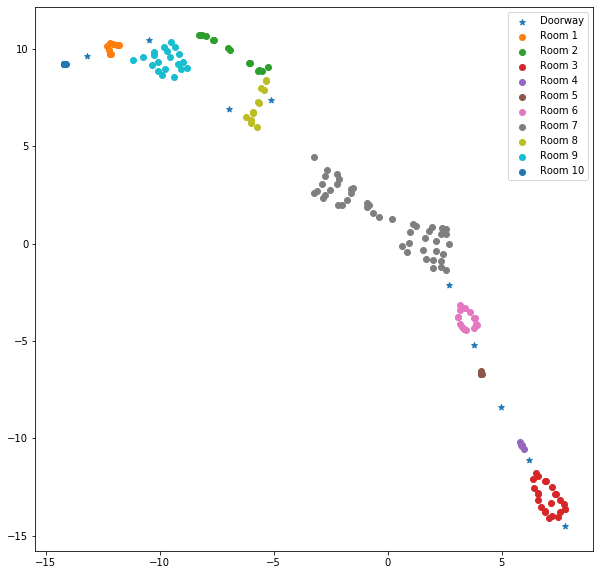

In [88]:
figure = plt.figure(figsize=(10, 10))
data = sf_embedded[rooms == 0]
plt.scatter(data[:, 0], data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    data = sf_embedded[rooms == i]
    plt.scatter(data[:, 0], data[:, 1], label='Room ' + str(i))
plt.legend()